In [1]:
import sqlite3
import pandas as pd
import jinja2
import json
import matplotlib as plt

from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders
import smtplib
import logging




## Conocimiento de los datos

In [2]:
conexion = sqlite3.connect('database.sqlite')
cursor = conexion.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

tablas = cursor.fetchall()

In [3]:
for tabla in tablas:
    print(tabla[0])

apicall
commerce


In [4]:
conexion = sqlite3.connect('database.sqlite')
nombretabla='apicall'
df_apicall= pd.read_sql_query(f'SELECT * FROM {nombretabla};', conexion)
df_apicall

,date_api_call,commerce_id,ask_status,is_related
0,2024-10-21 18:31:16,GdEQ-MGb7-LXHa-y6cd,Successful,1.0
1,2024-10-13 17:12:08,GdEQ-MGb7-LXHa-y6cd,Successful,1.0
2,2024-12-23 01:02:06,Rh2k-J1o7-zndZ-cOo8,Successful,1.0
3,2024-07-11 07:24:35,GdEQ-MGb7-LXHa-y6cd,Successful,1.0
4,2024-06-28 11:43:52,Rh2k-J1o7-zndZ-cOo8,Successful,1.0
...,...,...,...,...
1499995,2024-06-28 05:22:39,Vj9W-c4Pm-ja0X-fC1C,Unsuccessful,NaN
1499996,2024-02-15 16:19:05,3VYd-4lzT-mTC3-DQN5,Unsuccessful,NaN
1499997,2024-04-18 04:51:55,GdEQ-MGb7-LXHa-y6cd,Successful,1.0
1499998,2024-12-26 00:38:28,KaSn-4LHo-m6vC-I4PU,Successful,0.0


la tabla 'apicall' contiene la data de las transacciones realizadas por la API

In [5]:
## Validacion de datos
print('Los valores NA de is_related, se distribuyen de la siguiente manera para ask_status')
print(df_apicall[df_apicall['is_related'].isnull()]['ask_status'].value_counts())

print('-'*70)
print('Los valores validos de is_related, se distribuyen de la siguiente manera para ask_status')
print(df_apicall[df_apicall['is_related'].notnull()]['ask_status'].value_counts())

## Debido a los datos no se pueden eliminar los valores nulos de 'is_relater'; debido a que se eliminaría el 100% de los Unsuccessful

Los valores NA de is_related, se distribuyen de la siguiente manera para ask_status
ask_status
Unsuccessful    299505
Name: count, dtype: int64
----------------------------------------------------------------------
Los valores validos de is_related, se distribuyen de la siguiente manera para ask_status
ask_status
Successful    1200495
Name: count, dtype: int64


<Axes: xlabel='commerce_id'>

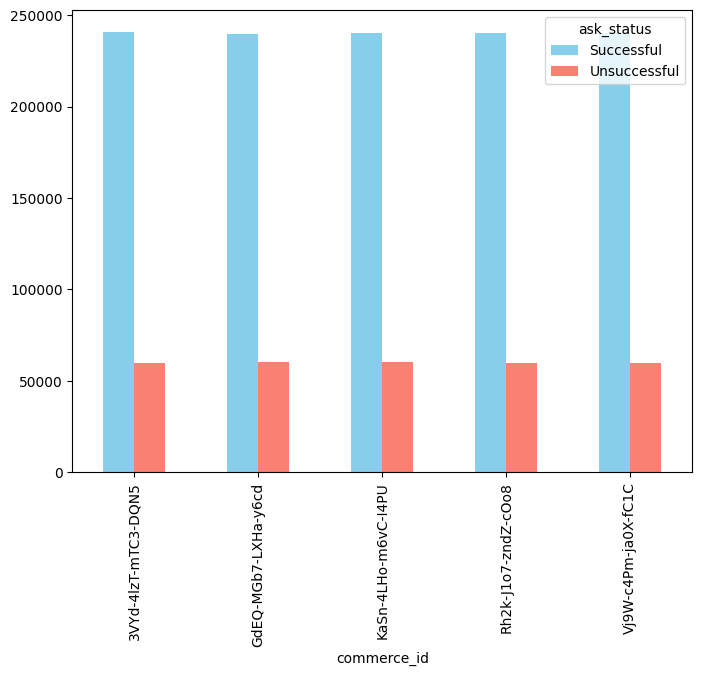

In [6]:
tabla_frecuencia_cliente = df_apicall.groupby(['commerce_id', 'ask_status']).size().unstack(fill_value=0)
tabla_frecuencia_cliente.plot(kind='bar', figsize=(8,6), color=['skyblue', 'salmon'])


## La distribución de no exitosos se comporta de manera normal en la data para cada uno de los clientes (no depende del cliente)

<Axes: xlabel='mes'>

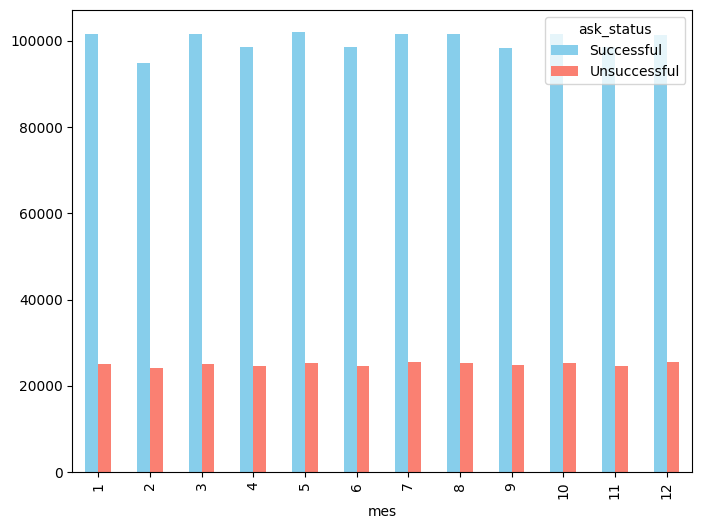

In [7]:
df_apicall['mes'] = pd.to_datetime(df_apicall['date_api_call']).dt.month

tabla_frecuencia_mes = df_apicall.groupby(['mes', 'ask_status']).size().unstack(fill_value=0)
tabla_frecuencia_mes.plot(kind='bar', figsize=(8,6), color=['skyblue', 'salmon'])

## La distribución de no exitosos se comporta de manera normal en la data para cada uno de los meses (no depende de la fecha)

## Existe información hasta el 31 de diciembre del 2024, este posible error se pasará por alto para proceder con el ejercicio

In [8]:
conexion = sqlite3.connect('database.sqlite')
nombretabla='commerce'
df_commerce= pd.read_sql_query(f'SELECT * FROM {nombretabla} limit 10;', conexion)
df_commerce


,commerce_id,commerce_nit,commerce_name,commerce_status,commerce_email
0,KaSn-4LHo-m6vC-I4PU,445470636,Innovexa Solutions,Inactive,innovexasolutions@microfitsof.com
1,Vj9W-c4Pm-ja0X-fC1C,452680670,NexaTech Industries,Active,nexatechindustries@gemaily.net
2,Rh2k-J1o7-zndZ-cOo8,198818316,QuantumLeap Inc.,Active,quantumleapinc.@gemaily.net
3,3VYd-4lzT-mTC3-DQN5,28960112,Zenith Corp.,Active,zenithcorp.@gemaily.net
4,GdEQ-MGb7-LXHa-y6cd,919341007,FusionWave Enterprises,Active,fusionwaveenterprises@microfitsof.com


La tabla 'comerce' contiene el maestro de clientes

## Consultas y definición de datos

In [9]:
## Definir los intervalos de los cobros, descuentos y sus respectivos valores

data = {
    'commerce_id': ['KaSn-4LHo-m6vC-I4PU', 'Vj9W-c4Pm-ja0X-fC1C', 'Rh2k-J1o7-zndZ-cOo8','3VYd-4lzT-mTC3-DQN5','GdEQ-MGb7-LXHa-y6cd'],
    'IntervalosExitos': [[float('inf')],[10000,20000,float('inf')],[float('inf')],[22000,float('inf')],[float('inf')]],
    'IntervalosCobros': [[300], [250,200,170], [600],[250,130],[300]],
    'IntervalosNoExitosos':[float('inf'),float('inf'),float('inf'),6000,4501],
    'Intervalosdescuentos':[0,0,0,5,8],
}
maestro_cobros = pd.DataFrame(data)
maestro_cobros


,commerce_id,IntervalosExitos,IntervalosCobros,IntervalosNoExitosos,Intervalosdescuentos
0,KaSn-4LHo-m6vC-I4PU,[inf],[300],inf,0
1,Vj9W-c4Pm-ja0X-fC1C,"[10000, 20000, inf]","[250, 200, 170]",inf,0
2,Rh2k-J1o7-zndZ-cOo8,[inf],[600],inf,0
3,3VYd-4lzT-mTC3-DQN5,"[22000, inf]","[250, 130]",6000.0,5
4,GdEQ-MGb7-LXHa-y6cd,[inf],[300],4501.0,8


In [10]:
## funcion para calcular los costos por tramos: en este caso se toma los limites superiores de cada tramo y se cacula el costo del tramo,
### se hace dinamico, en caso tal de cambiar uno de los tramos solo es cambiar la data de tramos, y este automaticamente se podrá actualizar para los cobros


def calcular_cobro(row):
    
    exitos = row['Successful']
    limiteanterior=0
    costo=0
    descuento=0
    for i in range(len(row['IntervalosExitos'])):
        if exitos>limiteanterior:
            if exitos <= row['IntervalosExitos'][i]:
                costo=costo+((exitos-limiteanterior)*(row['IntervalosCobros'][i]))
            else:
                costo=costo+((row['IntervalosExitos'][i]-limiteanterior)*(row['IntervalosCobros'][i]))
            limiteanterior=row['IntervalosExitos'][i]
    if row['Unsuccessful']>row['IntervalosNoExitosos']:
        descuento=costo*row['Intervalosdescuentos']/100
    cobrototal=costo-descuento


    return  costo,descuento,cobrototal

In [11]:
## funcion de correo, desde esta función, se le ingresa un dataFrame con la información del cliente y se envía la tabla resumen además de un archio con la información.
## Las credenciales se encuentran en el archivo credenciales_mail.json y son de prueba

def correo(dataframe):

    tabla_html = dataframe.to_html(index=False)
    destinatarios=dataframe['commerce_email'].iloc[0]
    try:
        with open(r'credenciales_mail.json') as file:
            cred = json.load(file)
        remitente=cred['username']
        host_activo=cred['host']
        puerto_activo=cred['puerto']
        sender = "No Reply <{remitente}"
        username = remitente
        receivers = destinatarios
        password = cred['psw']
        cliente=dataframe['commerce_name'].iloc[0]
        año_mes=dataframe['año_mes'].iloc[0]
        ruta_archivo=f'Factura_{cliente}_{año_mes}.xlsx'
        dataframe.to_excel(ruta_archivo,index=False)
        message = MIMEMultipart()
        message['From'] = sender
        message['To'] = ', '.join(receivers)
        message['Subject'] = "Alertas Factura"
        
        ## Verificar que el dataframe tenga data
        if not dataframe.empty:
            tabla_html = dataframe.to_html(index=False)
            body = f"""
            <html>
            <body>
                <p>Cordial saludo</p>
                <p>Comparto información de factura para el cliente {cliente}</p>
                {tabla_html}
            </body>
            </html>
            """
            message.attach(MIMEText(body, 'html', 'utf-8'))

            # Adjuntar el archivo
            try:
                with open(ruta_archivo, 'rb') as archivo_adjunto:
                    parte_adjunto = MIMEBase('application', 'vnd.openxmlformats-officedocument.spreadsheetml.sheet')
                    parte_adjunto.set_payload(archivo_adjunto.read())
                    encoders.encode_base64(parte_adjunto)  
                    parte_adjunto.add_header(
                        'Content-Disposition',
                        f'attachment; filename={ruta_archivo}'
                    )
                    message.attach(parte_adjunto)
            except Exception as e:
                print(f'Error al adjuntar el archivo: {e}')
            try:
                with smtplib.SMTP(host=host_activo, port=puerto_activo) as smtpObj:
                    smtpObj.starttls()
                    smtpObj.login(username, password)
                    smtpObj.sendmail(sender, receivers, message.as_string())
                    print("Correo enviado exitosamente")

            except Exception as e:

                print(f"Error al enviar el correo: {e}")

 

    except Exception as e:

        logging.error(f'Excepción capturada: {str(e)}')

## Funciones para leer los datos y hacer revisión de información

In [12]:

def consulta(desde, hasta):
    ## Procedemos a consultar las fechas solicitadas
    desde=desde+' 00:00:00'
    hasta=hasta+' 23:59:59'
    conexion = sqlite3.connect('database.sqlite')
    nombretabla='apicall'
    df_apicall= pd.read_sql_query(f"SELECT * FROM {nombretabla} where date_api_call between '{desde}' and '{hasta}';", conexion)
    df_apicall

    ## Confirguración de fechas
    df_apicall['fechas'] = pd.to_datetime(df_apicall['date_api_call']).dt.date
    df_apicall['mes'] = pd.to_datetime(df_apicall['fechas']).dt.month
    df_apicall['año'] = pd.to_datetime(df_apicall['fechas']).dt.year

    return df_apicall

## Vamos a proceder a definir los datos de factura

In [13]:
def Factura(df_apicall):
    ## Definimos columnas Dummies para exitosos y no exitosos 
    ## (es decir que si la iteracción es exitosa se marca un uno en 'Successful' y de lo contrario un 0, para el caso de 'Unsuccessful', funciona exatamente de forma inversa)
    df_apicall = pd.get_dummies(df_apicall, columns=['ask_status'], prefix='', prefix_sep='')
    df_apicall['Successful']=df_apicall['Successful'].astype(int)
    df_apicall['Unsuccessful']=df_apicall['Unsuccessful'].astype(int)
    
    ## Agrupamos la data para generar valores acumulados por mes y cliente
    df_factura=df_apicall.groupby(['año', 'mes','commerce_id'])[['Successful', 'Unsuccessful']].sum().reset_index()

    ## Generamos la union con la data del maestro de clientes y maestro de cobros
    df_factura=df_factura.merge(df_commerce,on='commerce_id',how='right')
    df_factura=df_factura.merge(maestro_cobros,on='commerce_id',how='right')

    ## usamos la funcion de cobros
    df_factura[['ValorFactura','Descuento','ValortotalSinIVA']]=df_factura.apply(calcular_cobro,axis=1).tolist()
    df_factura['ValortotalConIVA']=df_factura['ValortotalSinIVA']*1.19

    ## Generar formato
    def formato_pesos(x):
        return f"${x:,.2f}"
    df_factura['ValorFactura']=df_factura['ValorFactura'].apply(formato_pesos)
    df_factura['Descuento']=df_factura['Descuento'].apply(formato_pesos)
    df_factura['ValortotalSinIVA']=df_factura['ValortotalSinIVA'].apply(formato_pesos)
    df_factura['ValortotalConIVA']=df_factura['ValortotalConIVA'].apply(formato_pesos)
    df_factura['año_mes'] = df_factura['año'].astype(str) + '-' + df_factura['mes'].astype(str).str.zfill(2)

    ## Seleccionamos aquellas columnas que sean pertinentes
    df_factura=df_factura[['año_mes','commerce_name','commerce_nit','commerce_email','ValorFactura','Descuento','ValortotalSinIVA','ValortotalConIVA','Successful','Unsuccessful']]
    return(df_factura)

In [14]:
fecha_inicio='2024-07-01'
fecha_fin='2024-08-31'

## Generamos la tabla de Factura para cada cliente con el rango de fechas seleccionado
df_apicall=consulta(fecha_inicio,fecha_fin)
df_factura=Factura(df_apicall)

## Una vez tenemos la data de las facturas, se procede a generar los correos para cada uno de los clientes, solo con la información pertinente para cada uno de ellos
## Adicional se genera un back up de los datos de factura
for clientes in df_factura['commerce_nit'].unique().tolist():
    data=df_factura[df_factura['commerce_nit']==clientes]
    correo(data)


Correo enviado exitosamente
Correo enviado exitosamente
Correo enviado exitosamente
Correo enviado exitosamente
Correo enviado exitosamente


In [15]:
## Visualizamos la data total de factura
df_factura

,año_mes,commerce_name,commerce_nit,commerce_email,ValorFactura,Descuento,ValortotalSinIVA,ValortotalConIVA,Successful,Unsuccessful
0,2024-07,Innovexa Solutions,445470636,innovexasolutions@microfitsof.com,"$6,073,200.00",$0.00,"$6,073,200.00","$7,227,108.00",20244,5002
1,2024-08,Innovexa Solutions,445470636,innovexasolutions@microfitsof.com,"$6,109,200.00",$0.00,"$6,109,200.00","$7,269,948.00",20364,5074
2,2024-07,NexaTech Industries,452680670,nexatechindustries@gemaily.net,"$4,565,790.00",$0.00,"$4,565,790.00","$5,433,290.10",20387,5029
3,2024-08,NexaTech Industries,452680670,nexatechindustries@gemaily.net,"$4,560,860.00",$0.00,"$4,560,860.00","$5,427,423.40",20358,5030
4,2024-07,QuantumLeap Inc.,198818316,quantumleapinc.@gemaily.net,"$12,138,600.00",$0.00,"$12,138,600.00","$14,444,934.00",20231,5234
5,2024-08,QuantumLeap Inc.,198818316,quantumleapinc.@gemaily.net,"$12,182,400.00",$0.00,"$12,182,400.00","$14,497,056.00",20304,5066
6,2024-07,Zenith Corp.,28960112,zenithcorp.@gemaily.net,"$5,098,500.00",$0.00,"$5,098,500.00","$6,067,215.00",20394,5046
7,2024-08,Zenith Corp.,28960112,zenithcorp.@gemaily.net,"$5,103,500.00",$0.00,"$5,103,500.00","$6,073,165.00",20414,5038
8,2024-07,FusionWave Enterprises,919341007,fusionwaveenterprises@microfitsof.com,"$6,121,800.00","$489,744.00","$5,632,056.00","$6,702,146.64",20406,5115
9,2024-08,FusionWave Enterprises,919341007,fusionwaveenterprises@microfitsof.com,"$6,078,600.00","$486,288.00","$5,592,312.00","$6,654,851.28",20262,5117
